## Librerias y carga de datos

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("..\\data\\processed\\limpio_nulos.csv")
df["date"] = pd.to_datetime(df["date"])
df["last_commit"] = pd.to_datetime(df["last_commit"])
df.drop(columns="Unnamed: 0", inplace=True)


In [3]:
df.head()

,date,rank,repo_name,stars,forks,username,issues,last_commit,description
0,2018-12-18,1,awesome-python,58777,11448,vinta,439,2018-12-13 08:29:32+00:00,"A curated list of awesome Python frameworks, l..."
1,2018-12-18,2,system-design-primer,53575,7570,donnemartin,68,2018-12-18 11:20:56+00:00,Learn how to design large-scale systems. Prep ...
2,2018-12-18,3,models,46039,28053,tensorflow,1324,2018-12-18 02:29:33+00:00,Models and examples built with TensorFlow
3,2018-12-18,4,public-apis,45373,4707,toddmotto,5,2018-12-18 11:24:53+00:00,A collective list of free APIs for use in soft...
4,2018-12-18,5,youtube-dl,44956,7820,rg3,2566,2018-12-18 11:18:21+00:00,Command-line program to download videos from Y...


## days since last commit

En este apartado, vamos a crear un nuevo feature *days since last commit (days_since_lc)*. Ya que en el EDA observamos que pese a la poca correlación entre la variable *last_commit* y la target, se observaba cierta tendencia ascendente entre la cantida de forks y la proximidad con el presente del último commit. Con este nuevo feature, pretedemos mantener esa información mientras se evita la posible colinealidad que existe entre las variables *last_commmit* y *date*.

In [4]:
df_1 = df.copy()

In [5]:
lc_y_m_d = [x[0] for x in df_1["last_commit"].astype(str).str.split(" ")]

df_1["last_commit"] = lc_y_m_d

df_1["last_commit"] = pd.to_datetime(df_1["last_commit"])

df_1["last_commit"]

0        2018-12-13
1        2018-12-18
2        2018-12-18
3        2018-12-18
4        2018-12-18
            ...    
168682   2024-02-03
168683   2024-01-27
168684   2023-12-24
168685   2024-01-29
168686   2023-07-28
Name: last_commit, Length: 168687, dtype: datetime64[ns]

In [6]:
df_1["days_since_lc"] = (df_1["date"] - df_1["last_commit"]) / timedelta(days=1)
df_1.head() 

,date,rank,repo_name,stars,forks,username,issues,last_commit,description,days_since_lc
0,2018-12-18,1,awesome-python,58777,11448,vinta,439,2018-12-13,"A curated list of awesome Python frameworks, l...",5.0
1,2018-12-18,2,system-design-primer,53575,7570,donnemartin,68,2018-12-18,Learn how to design large-scale systems. Prep ...,0.0
2,2018-12-18,3,models,46039,28053,tensorflow,1324,2018-12-18,Models and examples built with TensorFlow,0.0
3,2018-12-18,4,public-apis,45373,4707,toddmotto,5,2018-12-18,A collective list of free APIs for use in soft...,0.0
4,2018-12-18,5,youtube-dl,44956,7820,rg3,2566,2018-12-18,Command-line program to download videos from Y...,0.0


<Axes: >

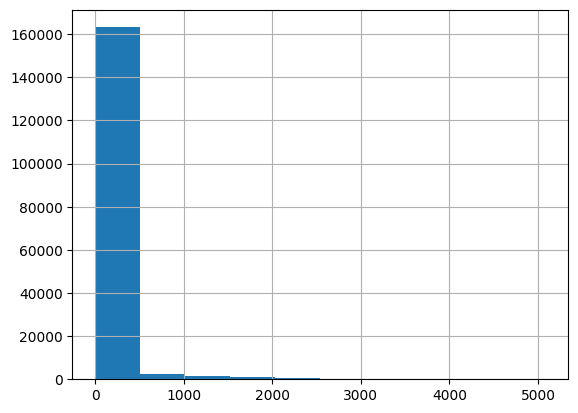

In [7]:
df_1["days_since_lc"].hist()

<Axes: xlabel='days_since_lc', ylabel='forks'>

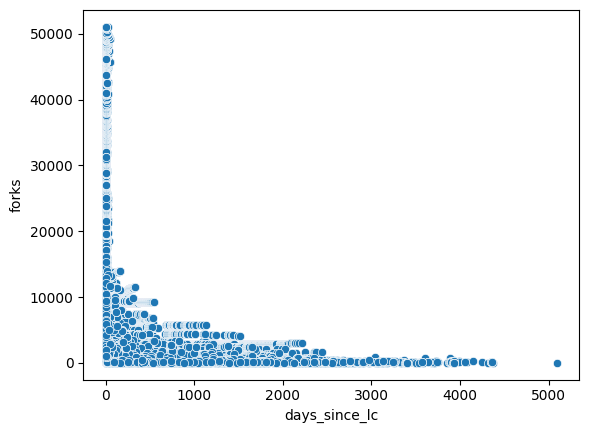

In [8]:
sns.scatterplot(df_1, x ="days_since_lc", y="forks")

<Axes: >

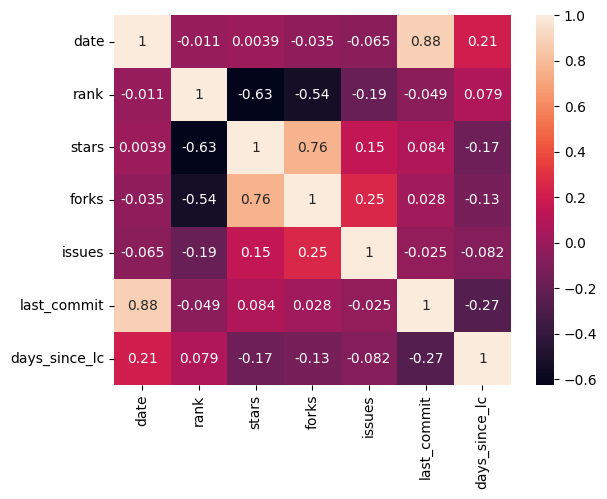

In [9]:
sns.heatmap(df_1.select_dtypes(exclude='O').corr(), annot=True)

Se puede observar en las gráficas que *days_since_lc* tiene un comportamiento y similar a *last_commit* y ademas hemos eliminado la posible colinealidad con la variable *date*. Por lo tanto vamos a eliminar el feature *last_commit*. 

In [10]:
df_1.drop(columns="last_commit", inplace=True)
df_1.head()

,date,rank,repo_name,stars,forks,username,issues,description,days_since_lc
0,2018-12-18,1,awesome-python,58777,11448,vinta,439,"A curated list of awesome Python frameworks, l...",5.0
1,2018-12-18,2,system-design-primer,53575,7570,donnemartin,68,Learn how to design large-scale systems. Prep ...,0.0
2,2018-12-18,3,models,46039,28053,tensorflow,1324,Models and examples built with TensorFlow,0.0
3,2018-12-18,4,public-apis,45373,4707,toddmotto,5,A collective list of free APIs for use in soft...,0.0
4,2018-12-18,5,youtube-dl,44956,7820,rg3,2566,Command-line program to download videos from Y...,0.0


## username

La columna *username* es una variable categórica, con información sobre el autor del repositorio. Como vimos en la exploración inicial, no coincide el número de users con el la cantidad de repositorios únicos, por lo tanto tiene que haber autores con mas de un repostorio. El trabajo de feature engineering que vamos a hacer con esta variable es crear una columna la cual nos indique si es un repostorio de un autor "famoso".

In [11]:
df_1.groupby("username")["repo_name"].value_counts()

username   repo_name                   
0k         shyaml                             1
0rpc       zerorpc-python                     1
0voice     interview_internal_reference     988
0x5e       wechat-deleted-friends             2
0xAX       linux-insides                   1134
                                           ... 
zulip      zulip                            615
zyantific  IDASkins                           1
zygmuntz   hyperband                          1
           phraug                             1
zzw922cn   Automatic_Speech_Recognition       1
Name: count, Length: 4265, dtype: int64

In [12]:
popular_users = list(df_1["username"].value_counts()[df_1["username"].value_counts() > 1].index)

In [29]:
n_repos = [df_1[df_1["username"] == x]["repo_name"].nunique() for x in popular_users]

In [18]:
print(len(popular_users), len(n_repos))

2113 2113


In [17]:
df_2 = pd.merge(df_1, pd.DataFrame({'username':popular_users, 'repos_by_user':n_repos}), 'outer', on='username')
df_2

,date,rank,repo_name,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,2018-12-18,1,awesome-python,58777,11448,vinta,439,"A curated list of awesome Python frameworks, l...",5.0,2.0
1,2018-12-19,1,awesome-python,58801,11454,vinta,439,"A curated list of awesome Python frameworks, l...",6.0,2.0
2,2018-12-20,1,awesome-python,58840,11455,vinta,439,"A curated list of awesome Python frameworks, l...",0.0,2.0
3,2018-12-21,1,awesome-python,58882,11465,vinta,440,"A curated list of awesome Python frameworks, l...",1.0,2.0
4,2018-12-22,1,awesome-python,58936,11470,vinta,439,"A curated list of awesome Python frameworks, l...",2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
168682,2024-01-30,33,gpt-engineer,48777,7923,gpt-engineer-org,20,"Specify what you want it to build, the AI asks...",2.0,2.0
168683,2024-01-31,35,gpt-engineer,48787,7930,gpt-engineer-org,20,"Specify what you want it to build, the AI asks...",1.0,2.0
168684,2024-02-01,38,gpt-engineer,48800,7929,gpt-engineer-org,21,"Specify what you want it to build, the AI asks...",1.0,2.0
168685,2024-02-02,38,gpt-engineer,48822,7931,gpt-engineer-org,21,"Specify what you want it to build, the AI asks...",1.0,2.0


In [18]:
df_2.isna().sum()

date                0
rank                0
repo_name           0
stars               0
forks               0
username            0
issues              0
description         0
days_since_lc       0
repos_by_user    1311
dtype: int64

In [19]:
df_2["repos_by_user"].fillna(1, inplace=True)

<Axes: >

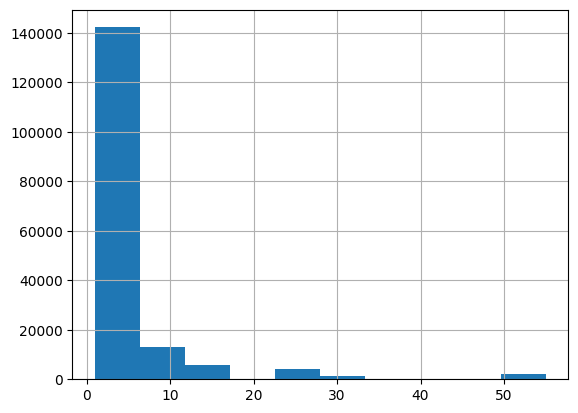

In [20]:
df_2["repos_by_user"].hist()

<Axes: xlabel='repos_by_user', ylabel='forks'>

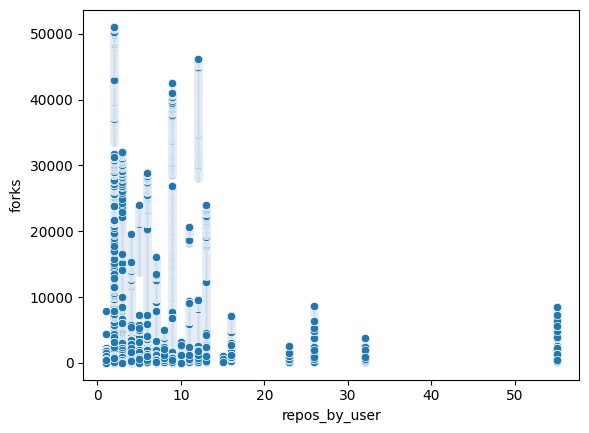

In [21]:
sns.scatterplot(df_2, x ="repos_by_user", y="forks")

<Axes: >

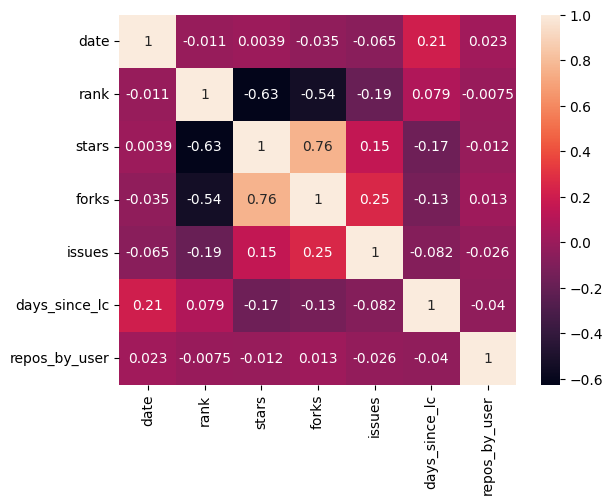

In [22]:
sns.heatmap(df_2.select_dtypes(exclude='O').corr(), annot=True)

Tras haber creado la columna *repos_by_user* y haber hecho un pequeño análisis exploratorio de la misma, se ve que existe cierta relación inversa entre el número de forks y los repositorios en el top del autor. Aún así, sigue quedando la duda de si el propio nombre del autor influye. Por lo tanto vamos a hacer un label encoder para poder explorar este punto.

In [23]:
df_3 = df_2.copy()
le = LabelEncoder()
df_3["username"] = le.fit_transform(df_3["username"])
df_3

,date,rank,repo_name,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,2018-12-18,1,awesome-python,58777,11448,3209,439,"A curated list of awesome Python frameworks, l...",5.0,2.0
1,2018-12-19,1,awesome-python,58801,11454,3209,439,"A curated list of awesome Python frameworks, l...",6.0,2.0
2,2018-12-20,1,awesome-python,58840,11455,3209,439,"A curated list of awesome Python frameworks, l...",0.0,2.0
3,2018-12-21,1,awesome-python,58882,11465,3209,440,"A curated list of awesome Python frameworks, l...",1.0,2.0
4,2018-12-22,1,awesome-python,58936,11470,3209,439,"A curated list of awesome Python frameworks, l...",2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
168682,2024-01-30,33,gpt-engineer,48777,7923,1581,20,"Specify what you want it to build, the AI asks...",2.0,2.0
168683,2024-01-31,35,gpt-engineer,48787,7930,1581,20,"Specify what you want it to build, the AI asks...",1.0,2.0
168684,2024-02-01,38,gpt-engineer,48800,7929,1581,21,"Specify what you want it to build, the AI asks...",1.0,2.0
168685,2024-02-02,38,gpt-engineer,48822,7931,1581,21,"Specify what you want it to build, the AI asks...",1.0,2.0


<Axes: >

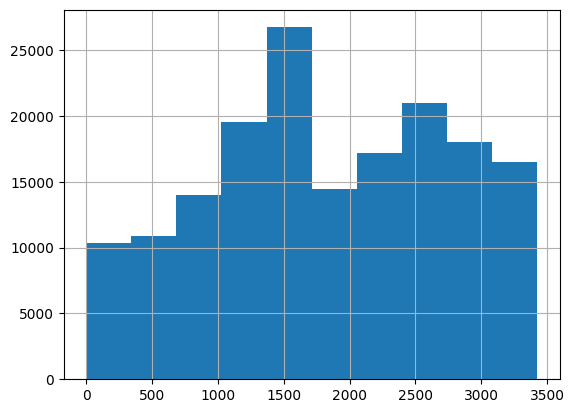

In [24]:
df_3["username"].hist()

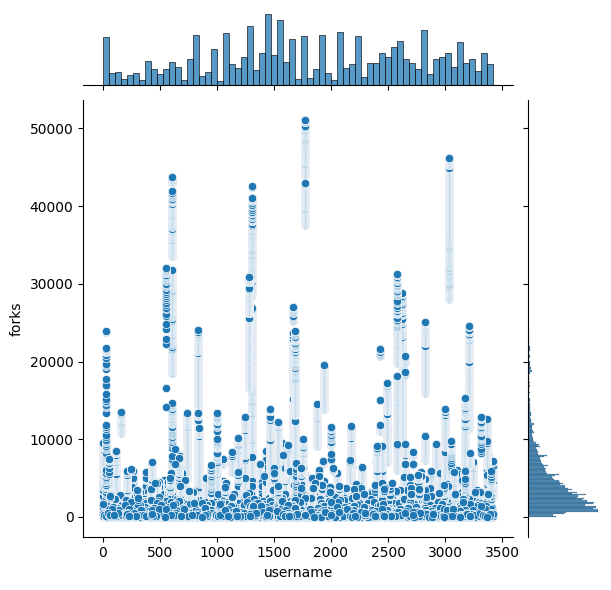

In [28]:
sns.jointplot(df_3, x="username", y="forks")

<Axes: >

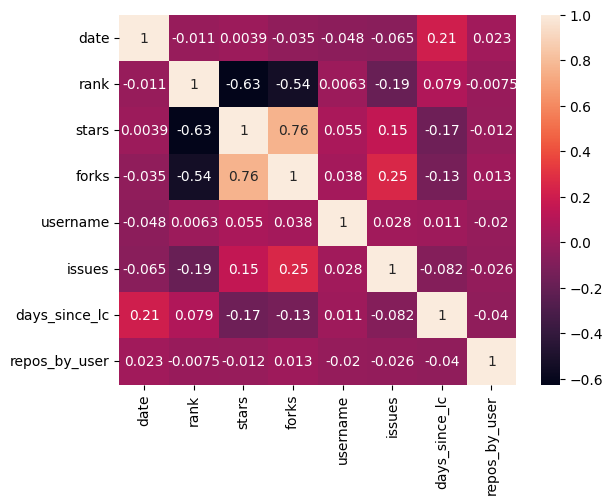

In [29]:
sns.heatmap(df_3.select_dtypes(exclude='O').corr(), annot=True)

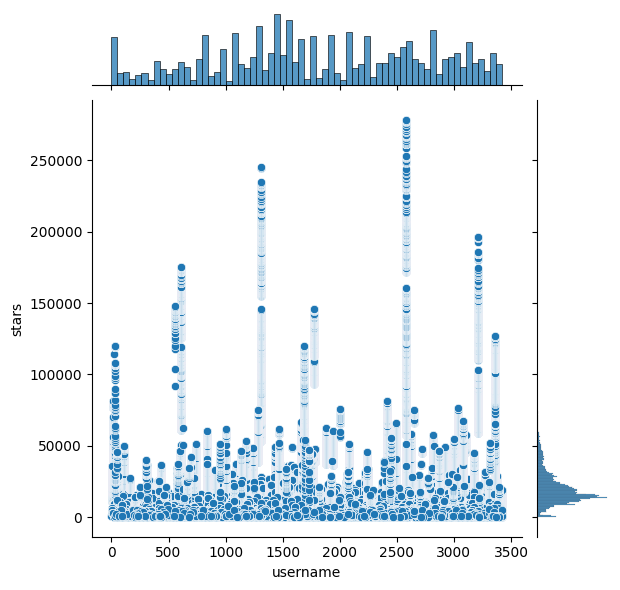

In [30]:
sns.jointplot(df_3, x="username", y="stars")

<Axes: xlabel='username', ylabel='forks'>

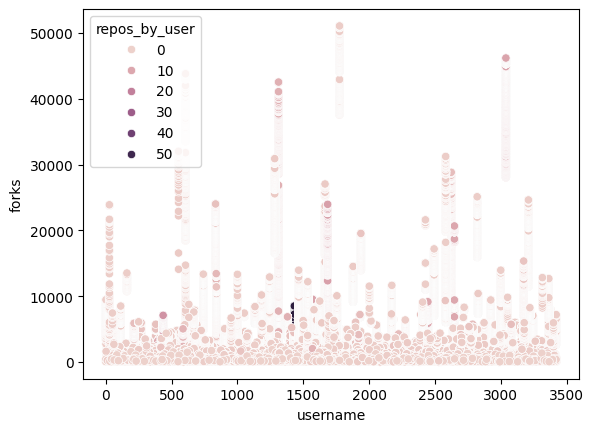

In [31]:
sns.scatterplot(df_3,hue="repos_by_user", x="username", y="forks")

Tras el procesamiento del featurer *username* utilizando `LabelEnconder`, observamos que sí aporta información distinta a la feature creada sobre si el repositorio era único o no de su autor. Por lo tanto mantenemos ambas columnas. 

## Guardando el DataFrame modificado

In [32]:
df_3.to_csv("..\\data\\processed\\feature_engeering.csv")